# Segmentation de clients d'un site e-commerce

Sommaire

## 0. Mise en place
* Imports des librairies
* Import du jeux de données

### 0.1 Import des librairies

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.feature_extraction import FeatureHasher
from matplotlib.gridspec import GridSpec
import p5Lib

### 0.2 Import des données

In [2]:
path = r'Data\\'

In [3]:
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(path + 'olist_orders_dataset.csv')
products = pd.read_csv(path + 'olist_products_dataset.csv')
sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv(path + 'product_category_name_translation.csv')

![img](https://i.imgur.com/HRhd2Y0.png)

In [4]:
# Collections for each dataset
datasets = [customers, geolocation, orders, order_items, order_payments,
            order_reviews, products, sellers, product_category_name_translation]
names = ['customer', 'geolocation', 'orders', 'order_items', 'order_payments',
         'order_reviews', 'products', 'sellers', 'product_category_name_translation']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,customer,99441,5,0,0,
1,geolocation,1000163,5,0,0,
2,orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,order_items,112650,7,0,0,
4,order_payments,103886,5,0,0,
5,order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,3095,4,0,0,
8,product_category_name_translation,71,2,0,0,


### 0.3 Assemblage du jeux de données
Jointure des différents dataset pour en avoir un unique

In [5]:
# Product information

full_products = order_items.join(products.set_index("product_id"),
                                 on="product_id")\
                           .join(sellers.set_index("seller_id"),
                                 on="seller_id")

In [6]:
# Order information

full_orders = orders.join(order_reviews.set_index("order_id"),
                          on='order_id')\
                    .join(order_payments.set_index("order_id"),
                          on='order_id')\
                    .join(full_products.set_index("order_id"),
                          on='order_id')

In [7]:
# Full data set with orders, products and clients

full_dataset = full_orders.join(customers.set_index("customer_id"),
                                on="customer_id")

In [8]:
full_dataset.shape

(119151, 39)

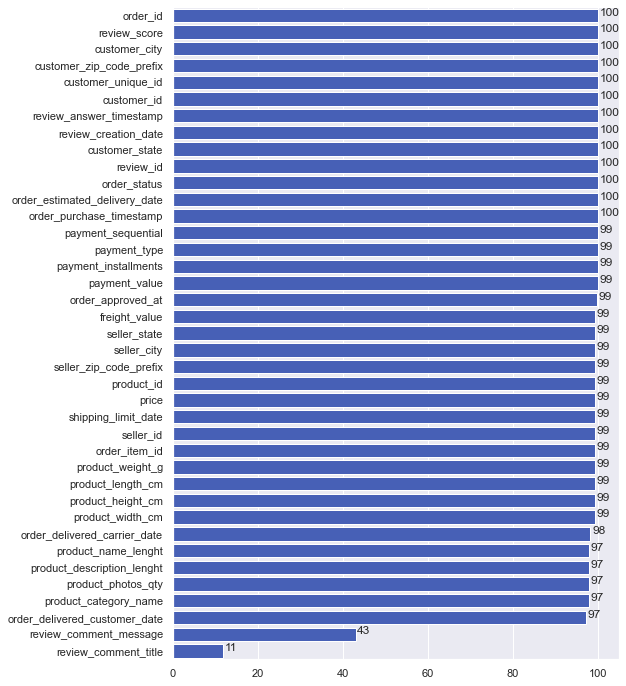

In [9]:
p5Lib.display_filling_of_col(full_dataset, show_values=True, figsize=(8, 12))

Le dataset est majoritairement très bien rempli.  
Il semblerait que les données manquantes des de review_comment provienne de consommateur n'ayant pas mis de message.  
Mais on note que la colonne review_score est complète à 100%.

## 1. NETTOYAGE

### 1.1 Conversion des dates

Pour réduire l'utilisation de la mémoire et pour faciliter l'utilisation des dates, nous convertisons les deonnées temporelle en 'datetime'.

In [10]:
# Converting to datetime

cols_to_timestamp = ["order_approved_at",
                     "order_delivered_carrier_date",
                     "order_delivered_customer_date",
                     "order_estimated_delivery_date",
                     "order_purchase_timestamp",
                     "review_answer_timestamp",
                     "review_creation_date",
                     "shipping_limit_date"]

for col in cols_to_timestamp:
    full_dataset[col] = pd.to_datetime(full_dataset[col],
                                       format='%Y-%m-%d %H:%M:%S')

In [11]:
# Converting to string

full_dataset["seller_zip_code_prefix"] = full_dataset\
                                        .loc[:, "seller_zip_code_prefix"].astype("str")
full_dataset["customer_zip_code_prefix"] = full_dataset["customer_zip_code_prefix"]\
                                           .astype(str)

### 1.2 Analyse des variables *customer_id* et *customer_unique_id*

In [12]:
# Getting the maximum number of 'customer_unique_id'
# associated to a single 'customer_id'
full_dataset\
    .groupby(by='customer_id')['customer_unique_id']\
    .nunique()\
    .describe()

count    99441.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: customer_unique_id, dtype: float64

In [13]:
# Getting the maximum number of 'customer_id'
# associated to a single 'customer_unique_id'
full_dataset\
    .groupby(by='customer_unique_id')['customer_id']\
    .nunique()\
    .describe()

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: customer_id, dtype: float64

L'identifiant *customer_unique_id* peut avoir jusqu'à 17 *customer_id* différent.  
Il à donc l'air plus spécifique.

### 1.3 Affinement des types de données

In [14]:
p5Lib.downcast(full_dataset);

Column review_score downcasted from int64 to int8.
Column payment_sequential downcasted from float64 to float32.
Column payment_installments downcasted from float64 to float32.
Column payment_value downcasted from float64 to float32.
Column order_item_id downcasted from float64 to float32.
Column price downcasted from float64 to float32.
Column freight_value downcasted from float64 to float32.
Column product_name_lenght downcasted from float64 to float32.
Column product_description_lenght downcasted from float64 to float32.
Column product_photos_qty downcasted from float64 to float32.
Column product_weight_g downcasted from float64 to float32.
Column product_length_cm downcasted from float64 to float32.
Column product_height_cm downcasted from float64 to float32.
Column product_width_cm downcasted from float64 to float32.


### 1.4 Gestion des lignes dupliquées

In [15]:
nb_rows_before_dropping_duplicates = len(full_dataset)
full_dataset = full_dataset.drop_duplicates()

print("Number of dropped duplicated rows:",
      nb_rows_before_dropping_duplicates - len(full_dataset))
print("Number of remaining rows:", len(full_dataset))

Number of dropped duplicated rows: 0
Number of remaining rows: 119151


### 1.5 Gestion des valeurs manquantes

In [16]:
import importlib
importlib.reload(p5Lib);

In [17]:
# Filling the missing values for comment title and comment message by ''
full_dataset[['review_comment_title', 'review_comment_message']
] = full_dataset[['review_comment_title', 'review_comment_message']
].fillna(value='')

# Checking the results of imputation
p5Lib.global_filling_rate(full_dataset)

DataFrame has 119151 rows and 39 columns.

Global filling rate of the DataFrame: 99.44%
Missing values in the DataFrame: 25940 (0.56%)

Number of rows with missing values: 5078 (4.26%)
Number of columns with missing values: 23 (58.97%)


In [18]:
full_dataset = p5Lib.fillingrate_filter_rows(full_dataset, 0.8)

Number of rows with a filling rate below 80.00%: 852 rows.


In [19]:
# Displays the global filling rate of the DataFrame
p5Lib.global_filling_rate(full_dataset)

# Display filling rate and number of missing values for each feature
p5Lib.columns_filling_rate(full_dataset, missing_only=True)

DataFrame has 118299 rows and 39 columns.

Global filling rate of the DataFrame: 99.77%
Missing values in the DataFrame: 10633 (0.23%)

Number of rows with missing values: 4226 (3.57%)
Number of columns with missing values: 15 (38.46%)


,nb_values,missing_values,filling_rate
order_delivered_customer_date,115711.0,2588.0,0.978123
product_category_name,116609.0,1690.0,0.985714
product_name_lenght,116609.0,1690.0,0.985714
product_description_lenght,116609.0,1690.0,0.985714
product_photos_qty,116609.0,1690.0,0.985714
order_delivered_carrier_date,117045.0,1254.0,0.989400
order_approved_at,118284.0,15.0,0.999873
payment_sequential,118296.0,3.0,0.999975
payment_type,118296.0,3.0,0.999975
payment_installments,118296.0,3.0,0.999975


In [20]:
# Proceed to column-wise imputations (based on dtypes)
data_items = p5Lib.smart_imputation(full_dataset)

# Inspect results of imputation
p5Lib.global_filling_rate(full_dataset)

# Display filling rate and number of missing values for each feature
p5Lib.columns_filling_rate(full_dataset, missing_only=True)

DataFrame has 118299 rows and 39 columns.

Global filling rate of the DataFrame: 99.77%
Missing values in the DataFrame: 10633 (0.23%)

Number of rows with missing values: 4226 (3.57%)
Number of columns with missing values: 15 (38.46%)


,nb_values,missing_values,filling_rate
order_delivered_customer_date,115711.0,2588.0,0.978123
product_category_name,116609.0,1690.0,0.985714
product_name_lenght,116609.0,1690.0,0.985714
product_description_lenght,116609.0,1690.0,0.985714
product_photos_qty,116609.0,1690.0,0.985714
order_delivered_carrier_date,117045.0,1254.0,0.989400
order_approved_at,118284.0,15.0,0.999873
payment_sequential,118296.0,3.0,0.999975
payment_type,118296.0,3.0,0.999975
payment_installments,118296.0,3.0,0.999975


In [21]:
# Delete rows with missing values
full_dataset = p5Lib.fillingrate_filter_rows(full_dataset, 0.999)

Number of rows with a filling rate below 99.90%: 4226 rows.


### 1.5 Suppression des outliers

In [22]:
# Deleting products that have a weight <= 0

print(f"Avant : {full_dataset.shape[0]}\n\
Nb supprimé : {full_dataset.shape[0] - full_dataset[full_dataset['product_weight_g'] > 0].shape[0]} \
| {(full_dataset.shape[0] - full_dataset[full_dataset['product_weight_g'] > 0].shape[0]) / full_dataset.shape[0] * 100:.2f} %")
full_dataset = full_dataset[full_dataset["product_weight_g"] > 0]
print(f"Apres : {full_dataset.shape[0]}")

Avant : 114073
Nb supprimé : 8 | 0.01 %
Apres : 114065


In [23]:
full_dataset.shape[0] - full_dataset[~((full_dataset['order_status'] == 'canceled') & (full_dataset["order_delivered_customer_date"].notnull()))].shape[0]

7

In [24]:
# Deleting canceled orders that are marked as delivered

nb_line_before_date_preproc = full_dataset.shape[0]

full_dataset = full_dataset[~((full_dataset['order_status'] == 'canceled') & (full_dataset["order_delivered_customer_date"].notnull()))]

In [25]:
# Deleting orders with incoherent event flow :
# 1) order_approved_at < order_delivered_carrier_date < order_delivered_customer_date 
#    < review_creation_date < review_answer_timestamp
# 2) order_approved_at < shipping_limit_date

In [26]:
full_dataset[(full_dataset["order_approved_at"] \
                              >= \
                              full_dataset["order_delivered_carrier_date"])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04,5a8608437f4b52bec5cd143f37258b5e,5,...,20.0,20.0,20.0,71931.0,brasilia,DF,ccafc1c3f270410521c3c6f3b249870f,74820,goiania,GO
64,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,delivered,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15,c7862c2b2f4259f9b1173a9c14e737e5,4,...,20.0,20.0,20.0,37175.0,ilicinea,MG,0e764fc1a13e47e900c3d59a989753e8,36045,juiz de fora,MG
64,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,delivered,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15,c7862c2b2f4259f9b1173a9c14e737e5,4,...,40.0,25.0,57.0,30111.0,belo horizonte,MG,0e764fc1a13e47e900c3d59a989753e8,36045,juiz de fora,MG
199,58d4c4747ee059eeeb865b349b41f53a,1755fad7863475346bc6c3773fe055d3,delivered,2018-07-21 12:49:32,2018-07-26 23:31:53,2018-07-24 12:57:00,2018-07-25 23:58:19,2018-07-31,9c5896eab584422a7f679b658edaf0a8,5,...,17.0,10.0,15.0,12940.0,atibaia,SP,a5314ac290a8b141491e987ae37aa7cc,13454,santa barbara d'oeste,SP
210,412fccb2b44a99b36714bca3fef8ad7b,c6865c523687cb3f235aa599afef1710,delivered,2018-07-22 22:30:05,2018-07-23 12:31:53,2018-07-23 12:24:00,2018-07-24 19:26:42,2018-07-31,a73c293bed304f473f5b0471f1223f99,5,...,18.0,105.0,30.0,7074.0,guarulhos,SP,95aec963a6193f24401417870b648031,7600,mairipora,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99091,240ead1a7284667e0ec71d01f80e4d5e,fcdd7556401aaa1c980f8b67a69f95dc,delivered,2018-07-02 16:30:02,2018-07-05 16:17:59,2018-07-05 14:11:00,2018-07-10 23:21:47,2018-07-24,72505fdb5e2419bd9e3c48c3a05bd01f,4,...,26.0,41.0,26.0,4361.0,sao paulo,SP,083f9c55bf04dc9af3749412568f9f6e,4719,sao paulo,SP
99230,78008d03bd8ef7fcf1568728b316553c,043e3254e68daf7256bda1c9c03c2286,delivered,2018-07-03 13:11:13,2018-07-05 16:32:52,2018-07-03 12:57:00,2018-07-10 17:47:39,2018-07-23,4140f2b38a5447bb90d453256604d8a3,5,...,30.0,20.0,70.0,9571.0,sao caetano do sul,SP,a2fb4a981e80db81e95c63cb85d3473b,17501,marilia,SP
99266,76a948cd55bf22799753720d4545dd2d,3f20a07b28aa252d0502fe7f7eb030a9,delivered,2018-01-30 02:41:30,2018-02-04 23:31:46,2018-01-31 18:11:58,2018-03-18 20:08:50,2018-03-02,ae0039085c486a7c94314c9430789af6,1,...,19.0,4.0,11.0,3126.0,sao paulo,SP,43aa3086b95f386b014b1b45de46554c,57035,maceio,AL
99377,a6bd1f93b7ff72cc348ca07f38ec4bee,6d63fa86bd2f62908ad328325799152f,delivered,2018-04-20 17:28:40,2018-04-24 19:26:10,2018-04-23 17:18:40,2018-04-28 17:38:42,2018-05-15,eb4c94cf604d9cf4d4442890ac33797d,5,...,50.0,10.0,40.0,8550.0,poa,SP,9108b540419f20edc605468f3966813b,15093,sao jose do rio preto,SP


In [27]:
# Deleting orders where order_approved_at < order_delivered_carrier_date

# full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
#                               >= \
#                               full_dataset["order_delivered_carrier_date"])]

In [28]:
full_dataset[(full_dataset["order_approved_at"] \
                              >= \
                              full_dataset["order_delivered_customer_date"])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
199,58d4c4747ee059eeeb865b349b41f53a,1755fad7863475346bc6c3773fe055d3,delivered,2018-07-21 12:49:32,2018-07-26 23:31:53,2018-07-24 12:57:00,2018-07-25 23:58:19,2018-07-31,9c5896eab584422a7f679b658edaf0a8,5,...,17.0,10.0,15.0,12940.0,atibaia,SP,a5314ac290a8b141491e987ae37aa7cc,13454,santa barbara d'oeste,SP
483,4df92d82d79c3b52c7138679fa9b07fc,ba0660bf3fffe505ee892e153a2fbd49,delivered,2018-07-24 11:32:11,2018-07-29 23:30:52,2018-07-26 14:46:00,2018-07-27 18:55:57,2018-08-06,b45c75845de7e21f4823abad933fb58d,5,...,35.0,23.0,35.0,3204.0,sao paulo,SP,cd2624b9b75d83efb640f7204232511e,4753,sao paulo,SP
483,4df92d82d79c3b52c7138679fa9b07fc,ba0660bf3fffe505ee892e153a2fbd49,delivered,2018-07-24 11:32:11,2018-07-29 23:30:52,2018-07-26 14:46:00,2018-07-27 18:55:57,2018-08-06,b45c75845de7e21f4823abad933fb58d,5,...,35.0,23.0,35.0,3204.0,sao paulo,SP,cd2624b9b75d83efb640f7204232511e,4753,sao paulo,SP
1986,6e57e23ecac1ae881286657694444267,2dda54e25d0984e12705c84d4030e6e0,delivered,2018-08-09 17:36:47,2018-08-20 15:55:42,2018-08-14 13:26:00,2018-08-17 16:45:45,2018-09-06,74e1b826772884d613776bebb18da18e,3,...,34.0,4.0,22.0,9628.0,sao bernardo do campo,SP,71692b73230707ce0f95d8a6091c22b4,27946,macae,RJ
3659,f222c56f035b47dfa1e069a88235d730,b74ca180d63f9ae0443e4e13a2f5bdaf,delivered,2018-01-30 09:43:45,2018-02-04 23:31:47,2018-01-31 19:48:44,2018-02-01 20:10:38,2018-02-15,b988c1daec78d156cc973f0da2e1f607,5,...,35.0,15.0,35.0,1233.0,sao paulo,SP,398957fce766920db4c4b206d7c9aa85,9271,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91801,4387477eec4b3c89b39f3f454940d059,dbbbdb6ab9a7d8e3fc39a907f456bf19,delivered,2018-08-09 20:45:10,2018-08-20 15:56:29,2018-08-14 12:35:00,2018-08-15 14:56:43,2018-08-14,e88b602ca3160acddcd03ea4179a95bc,4,...,67.0,11.0,47.0,3333.0,sao paulo,SP,c1dffa0ed8695e4823f90ae4550e336e,5412,sao paulo,SP
91801,4387477eec4b3c89b39f3f454940d059,dbbbdb6ab9a7d8e3fc39a907f456bf19,delivered,2018-08-09 20:45:10,2018-08-20 15:56:29,2018-08-14 12:35:00,2018-08-15 14:56:43,2018-08-14,e88b602ca3160acddcd03ea4179a95bc,4,...,67.0,11.0,47.0,3333.0,sao paulo,SP,c1dffa0ed8695e4823f90ae4550e336e,5412,sao paulo,SP
93680,4f3a6e28d764cf896b1fceb0028422c8,e24fceba7ac4b1b1cd1884f05ba68e9d,delivered,2018-07-03 09:34:16,2018-07-05 16:21:50,2018-07-03 16:52:00,2018-07-05 13:32:49,2018-07-20,79e2c699be312b209b94a397947a5e48,5,...,29.0,5.0,21.0,2274.0,sao paulo,SP,7410c7ed56c93d4eee17a7b7b3a75b3e,13056,campinas,SP
94359,9c3186381b733d4304e2e416afc6bbc1,a4bd2fc7bf4fc0061011ef71a2208d63,delivered,2018-07-28 20:49:05,2018-08-02 23:30:29,2018-07-31 14:09:00,2018-08-01 19:04:37,2018-08-03,77983fb2d99acdf83631e3f3be5b4a70,5,...,20.0,35.0,15.0,13900.0,amparo,SP,dd6df6bc626f435236526c7f50b43d26,12940,atibaia,SP


In [29]:
# Deleting orders where order_approved_at < order_delivered_customer_date

# full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
#                               >= \
#                               full_dataset["order_delivered_customer_date"])]

In [30]:
full_dataset[(full_dataset["order_approved_at"] \
                              >= \
                              full_dataset["review_creation_date"])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
1986,6e57e23ecac1ae881286657694444267,2dda54e25d0984e12705c84d4030e6e0,delivered,2018-08-09 17:36:47,2018-08-20 15:55:42,2018-08-14 13:26:00,2018-08-17 16:45:45,2018-09-06,74e1b826772884d613776bebb18da18e,3,...,34.0,4.0,22.0,9628.0,sao bernardo do campo,SP,71692b73230707ce0f95d8a6091c22b4,27946,macae,RJ
11738,cf72398d0690f841271b695bbfda82d2,2b7fff075bda701552485ef3f0810257,delivered,2017-09-01 18:45:33,2017-09-13 22:04:39,2017-09-04 20:12:41,2017-09-11 14:15:02,2017-09-21,59a744fca1671a2af96f5e9d94fa2d4a,5,...,40.0,20.0,40.0,6060.0,osasco,SP,0a230b3fdaae7f47c5a5c39a4b73a340,2992,sao paulo,SP
14562,1fab4ac9d85079b3da72a11475ae1685,f831c1fa80308975ec2b58e4877328e0,delivered,2017-09-01 19:04:22,2017-09-13 22:06:11,2017-09-04 13:10:23,2017-09-08 20:13:03,2017-09-20,02c96d8d6734cc1422ec6ef7464ae448,5,...,18.0,13.0,15.0,14840.0,guariba,SP,d121ceaccf4c241eae9a5f97cc661ccf,13610,leme,SP
18097,0467205a89711e4ec8e70ef2277e3287,90b8af517fbab96fb08d0115dffdc570,delivered,2018-07-03 10:30:52,2018-07-05 16:40:30,2018-07-03 13:12:00,2018-07-04 22:42:41,2018-07-16,570cd48b3af433e758691eac885dd5dc,5,...,20.0,10.0,15.0,2258.0,sao paulo,SP,f900fc2f1cd425f450ed45de58815199,3433,sao paulo,SP
24823,6d1832bd42dccbd91d1ce32da7f54492,1d12f3eea210892c245c9be2bd17a93c,delivered,2018-07-01 12:02:12,2018-07-05 16:19:44,2018-07-03 19:25:00,2018-07-04 22:37:38,2018-07-16,7fb8d3a478e8ae07546885b5888225cc,5,...,16.0,11.0,11.0,13840.0,mogi guacu,SP,b1f7aa0f8737c9e24aa42df4a5b1f986,9820,sao bernardo do campo,SP
25411,6b80bb20190715d71c43efff617bd659,2fedecfd993b8b3fa889d00eee230748,delivered,2017-02-19 01:15:03,2017-03-01 10:51:46,2017-02-22 16:05:29,2017-02-24 14:27:26,2017-03-17,69c1b8a9952b4ff9352c30cbe0d0b980,5,...,17.0,28.0,11.0,13290.0,louveira,SP,4687b78e990956109c4019200e3ac062,19906,ourinhos,SP
27309,c3b8c17ee15e0e798c2e178b7d4c7f42,67a5fd09c67dd51115ca8044b4afdc34,delivered,2017-09-01 20:04:47,2017-09-13 22:08:55,2017-09-05 15:43:31,2017-09-11 16:43:46,2017-09-20,4634798978467c6817693995be44d535,3,...,24.0,5.0,20.0,14940.0,ibitinga,SP,1dd809dce0726b91fe230b6cbb0bcf42,13770,caconde,SP
27804,0e1501cd30758f584d1fa67cc6f9493a,63162a081407c40769b8b941dbbc7275,delivered,2018-07-02 16:16:03,2018-07-05 16:25:45,2018-07-03 14:36:00,2018-07-04 23:03:36,2018-07-17,766652c47d4c1b94b655ab3e09709ecf,5,...,27.0,23.0,27.0,13481.0,limeira,SP,52a7ee2fff9bca157d19972ad5825ed2,6702,cotia,SP
31211,bc4854efd86d9f42140c951c595d20c1,30aef21b6dd78da1334dd1164cc0b05e,delivered,2017-09-01 20:05:42,2017-09-13 22:00:51,2017-09-04 20:49:57,2017-09-06 22:15:45,2017-09-20,501080ee5530612c3d677c7683f8e960,5,...,37.0,35.0,32.0,13930.0,serra negra,SP,25d27a4142682b5d504dcc67caab8d6f,4909,sao paulo,SP
32412,ebc94658c583ab37ad4f8e9091c4bef2,92dbb92ac5c6b1822c3aa951d33e61d0,delivered,2018-04-14 08:22:43,2018-04-24 18:04:50,2018-04-26 15:57:00,2018-04-30 20:39:01,2018-05-03,d25026282e14fc531f0711246e121cc2,2,...,16.0,35.0,22.0,31730.0,belo horizonte,MG,5c96017028584678dd28c139566b87c0,34012,nova lima,MG


In [31]:
# Deleting orders where order_approved_at < review_creation_date

# full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
#                               >= \
#                               full_dataset["review_creation_date"])]

In [32]:
# Deleting orders where order_approved_at < review_answer_timestamp

# full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
#                              >= \
#                              full_dataset["review_answer_timestamp"])]

In [33]:
# Deleting orders where order_approved_at < shipping_limit_date

# full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
#                               >= \
#                               full_dataset["shipping_limit_date"])]

_order_delivered_carrierdate

In [34]:
# Deleting orders where order_delivered_carrier_date < order_delivered_customer_date

# full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"] \
#                               >= \
#                               full_dataset["order_delivered_customer_date"])]

In [35]:
# Deleting orders where order_delivered_carrier_date < review_creation_date

# full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"] \
#                               >= \
#                               full_dataset["review_creation_date"])]

_order_delivered_customerdate

In [36]:
# Deleting orders where order_delivered_customer_date < review_creation_date

# full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"]\
#                               >= \
#                               full_dataset["review_creation_date"])]

In [37]:
# Deleting orders where order_delivered_customer_date < review_answer_timestamp

# full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"] \
#                               >= \
#                               full_dataset["review_answer_timestamp"])]

_review_creationdate

In [38]:
# Deleting orders where review_creation_date < review_answer_timestamp

# full_dataset = full_dataset[~(full_dataset["review_creation_date"] \
#                               >= \
#                               full_dataset["review_answer_timestamp"])]

In [39]:
print(f"Lignes supprimés : {nb_line_before_date_preproc - full_dataset.shape[0]} | \
{(nb_line_before_date_preproc - full_dataset.shape[0]) / nb_line_before_date_preproc * 100:.2f} %\n\
Nb de lignes : {full_dataset.shape[0]}")

Lignes supprimés : 7 | 0.01 %
Nb de lignes : 114058


### 1.5 Suppression des lignes totalement vide

In [40]:
print(f"Lignes entièrement vides : {full_dataset.shape[0] - full_dataset.dropna(how='all', axis=1).shape[0]}")

Lignes entièrement vides : 0


## 2. Selection des données

In [41]:
# Data since january 2017

full_dataset = full_dataset[full_dataset["order_purchase_timestamp"].dt.year > 2016]

## 3. Feature Engineering

Segmentation RMFP (Récence – Fréquence – Montant – Produit)  
[Average online shopping value in Brazil from 2017 to 2020](https://www.statista.com/statistics/255337/average-b2c-e-commerce-sales-per-digital-buyer-in-brazil/)

In [42]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113724 entries, 0 to 99440
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113724 non-null  object        
 1   customer_id                    113724 non-null  object        
 2   order_status                   113724 non-null  object        
 3   order_purchase_timestamp       113724 non-null  datetime64[ns]
 4   order_approved_at              113724 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113724 non-null  datetime64[ns]
 6   order_delivered_customer_date  113724 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113724 non-null  datetime64[ns]
 8   review_id                      113724 non-null  object        
 9   review_score                   113724 non-null  int8          
 10  review_comment_title           113724 non-null  object        
 11  r

### 3.1 Variable 'review_comment_title' en booléen

In [43]:
full_dataset['review_comment_title_bool'] = full_dataset['review_comment_title'] != ''

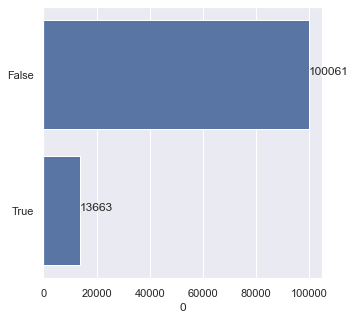

In [44]:
p5Lib.display_cate_bar(full_dataset, 'review_comment_title_bool')

In [45]:
full_dataset['order_purchase_year'] = full_dataset['order_purchase_timestamp'].apply(lambda x: x.year)
full_dataset['order_purchase_month'] = full_dataset['order_purchase_timestamp'].apply(lambda x: x.month)

### 3.2 Variable 'review_comment_message' en booléen

In [46]:
full_dataset['review_comment_message_bool'] = full_dataset['review_comment_message'] != ''

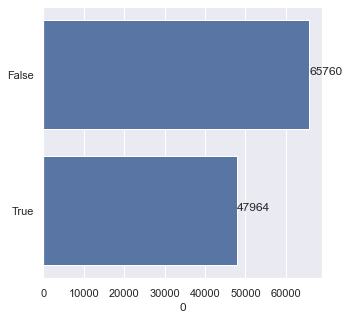

In [47]:
p5Lib.display_cate_bar(full_dataset, 'review_comment_message_bool')

In [132]:
import importlib
importlib.reload(p5Lib);

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


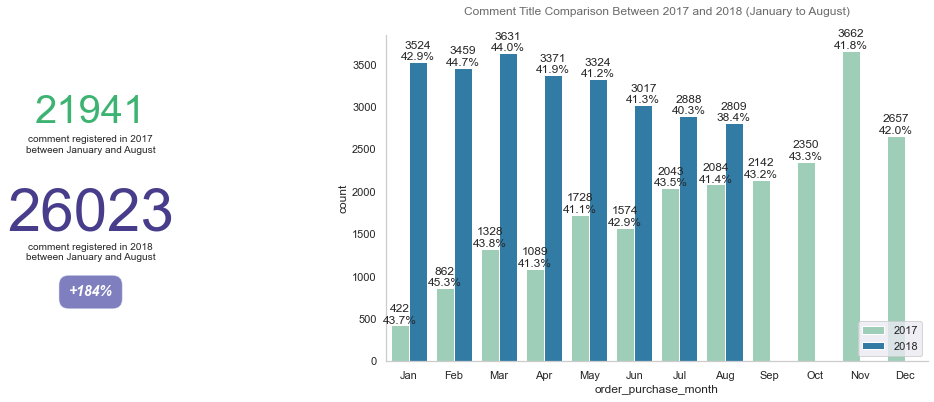

In [133]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 6))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare_comment = full_dataset.query('order_purchase_year in (2017, 2018) & review_comment_message_bool == True')
year_orders = df_orders_compare_comment['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'comment registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'comment registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
p5Lib.single_countplot(df_orders_compare_comment, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax2.set_xticklabels(month_label)
ax2.set_title('Comment Title Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
it = 1
for p in ax2.patches:
    year = 2017
    if it > 12:
        year = 2018
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    nb_order = full_dataset.query(f'order_purchase_year == {year} and order_purchase_month == {it}').shape[0]
    if year == 2018:
        nb_order = full_dataset.query(f'order_purchase_year == {year} and order_purchase_month == {it - 12}').shape[0]
    it +=1
    try:
        ax2.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / nb_order), (x.mean(), y), ha='center', va='bottom')
    except:
        pass
    
plt.legend(loc='lower right')
plt.show()

In [136]:
full_dataset['payment_sequential'].value_counts()

1.0     108866
2.0       3258
3.0        629
4.0        303
5.0        180
6.0        123
7.0         84
8.0         55
9.0         44
10.0        38
11.0        34
12.0        26
13.0        14
14.0        12
15.0        10
17.0         8
18.0         8
16.0         8
19.0         8
20.0         5
21.0         5
22.0         2
26.0         1
24.0         1
23.0         1
25.0         1
Name: payment_sequential, dtype: int64

In [142]:
full_dataset[['payment_sequential', 'payment_type']]

,payment_sequential,payment_type
0,1.0,credit_card
0,3.0,voucher
0,2.0,voucher
1,1.0,boleto
2,1.0,credit_card
...,...,...
99437,1.0,credit_card
99438,1.0,credit_card
99439,1.0,credit_card
99439,1.0,credit_card


In [148]:
pd.crosstab(full_dataset['payment_sequential'], full_dataset['payment_type'])

payment_type,boleto,credit_card,debit_card,voucher
payment_sequential,,,,
1.0,22128,83556,1580,1602
2.0,1,358,51,2848
3.0,0,1,1,627
4.0,0,0,0,303
5.0,0,0,0,180
6.0,0,0,0,123
7.0,0,0,0,84
8.0,0,0,0,55
9.0,0,0,0,44
